# Importing tf libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import time

# Data loader and generator

In [2]:
class InputPipeline:
  def __init__(self,batch_size=64):
    self.batch_size = batch_size

  @staticmethod
  def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    X_train = X_train.astype("float32")/255.0
    X_test = X_test.astype("float32")/255.0
    y_train = y_train.astype("int32")
    y_test = y_test.astype("int32")
    return X_train, y_train, X_test, y_test
  
  def data_generator(self,features,labels):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.batch(batch_size=self.batch_size,
                            drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

  def __call__(self):
    X_train, y_train, X_test, y_test = self.load_dataset()
    train_dataset = self.data_generator(X_train, y_train)
    test_dataset = self.data_generator(X_test, y_test)
    return train_dataset, test_dataset

# Show images and labels

In [3]:
class Visualize:
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def train_show(self):
    plt.figure(figsize=(15,15))
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.imshow(self.images[i])
      plt.title(self.labels[i])
      plt.subplots_adjust(wspace=1,
                          hspace=1)
    plt.show()
  
  def __call__(self):
    self.train_show()

# Train Teacher model

In [4]:
class TeacherModel:
  def __init__(self,train_dataset,
               test_dataset,
               image_width=32,
               image_height=32,
               classes=10,
               epochs=1):
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    self.image_width = image_width
    self.image_height = image_height 
    self.classes = classes
    self.epochs = epochs
  
  def xception_model(self):
    base_model = tf.keras.applications.ResNet50(include_top=False,
                                                   input_shape=(self.image_width,
                                                                self.image_height,
                                                                3))
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    out = tf.keras.layers.Dense(self.classes)(x)
    model = tf.keras.models.Model(base_model.input,out)
    return model
  
  def __call__(self):
    model = self.xception_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    model.fit(self.train_dataset,epochs=self.epochs,
              validation_data=self.test_dataset)
    score = model.evaluate(self.test_dataset,batch_size=64, verbose=0)
    print("Teacher Model acc: ", score[1])

# Train Student Mobilenet model

In [5]:
class StudentModel:
  def __init__(self,train_dataset,
               test_dataset,
               image_width=32,
               image_height=32,
               classes=10,
               epochs=1):
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    self.image_width = image_width
    self.image_height = image_height 
    self.classes = classes
    self.epochs = epochs
  
  def mobilenet_model(self):
    base_model = tf.keras.applications.MobileNetV3Small(include_top=False,
                                                   input_shape=(self.image_width,
                                                                self.image_height,
                                                                3))
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    out = tf.keras.layers.Dense(self.classes)(x)
    model = tf.keras.models.Model(base_model.input,out)
    return model
  
  def __call__(self):
    model = self.mobilenet_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    model.fit(self.train_dataset,epochs=self.epochs,
              validation_data=self.test_dataset)
    score = model.evaluate(self.test_dataset,batch_size=64, verbose=0)
    print("Student Model acc: ", score[1])

# Train Distilled Model

In [6]:
class DistillatedModel(tf.keras.models.Model):
  def __init__(self,teacher_model,student_model,
               temperature=2.0,alpha=0.9,beta=0.1):
    super(DistillatedModel,self).__init__()
    self.teacher_model = teacher_model
    self.student_model = student_model
    self.temperature = temperature
    self.alpha = alpha
    self.beta = beta
  
  def kd_loss(self,teacher_logits,student_logits):
    new_teacher_logits = tf.nn.softmax(teacher_logits / self.temperature)
    new_student_logits = tf.nn.softmax(student_logits / self.temperature)
    kdloss = tf.keras.losses.kl_divergence(new_teacher_logits,
                                           new_student_logits)
    return kdloss

  @staticmethod
  def student_loss(gt_labels,student_logits):
    studentloss = tf.keras.losses.sparse_categorical_crossentropy(gt_labels,
                                                                  student_logits,
                                                                  from_logits=True)
    return studentloss
  
  def distillation_loss(self,teacher_logits,student_logits,
                        gt_labels):
    kdloss= self.alpha * self.kd_loss(teacher_logits,student_logits)
    studentloss = self.beta * self.student_loss(gt_labels,student_logits)
    return kdloss + studentloss

  def train_step(self,data):
    images, labels = data
    
    teacher_logits = self.teacher_model(images, training=False)

    with tf.GradientTape() as tape:
      student_logits = self.student_model(images, training=True)
      loss = self.distillation_loss(teacher_logits,student_logits,labels)

    student_gradients = tape.gradient(loss,self.student_model.trainable_variables)
    self.optimizer.apply_gradients(zip(student_gradients,
                                       self.student_model.trainable_variables))
    
    return {"loss":loss}

  def test_step(self,data):
    images, labels = data

    teacher_logits = self.teacher_model(images,training=False)
    student_logits = self.student_model(images,training=False)

    loss = self.distillation_loss(teacher_logits,student_logits,labels)
    
    return {"loss":loss}
    


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


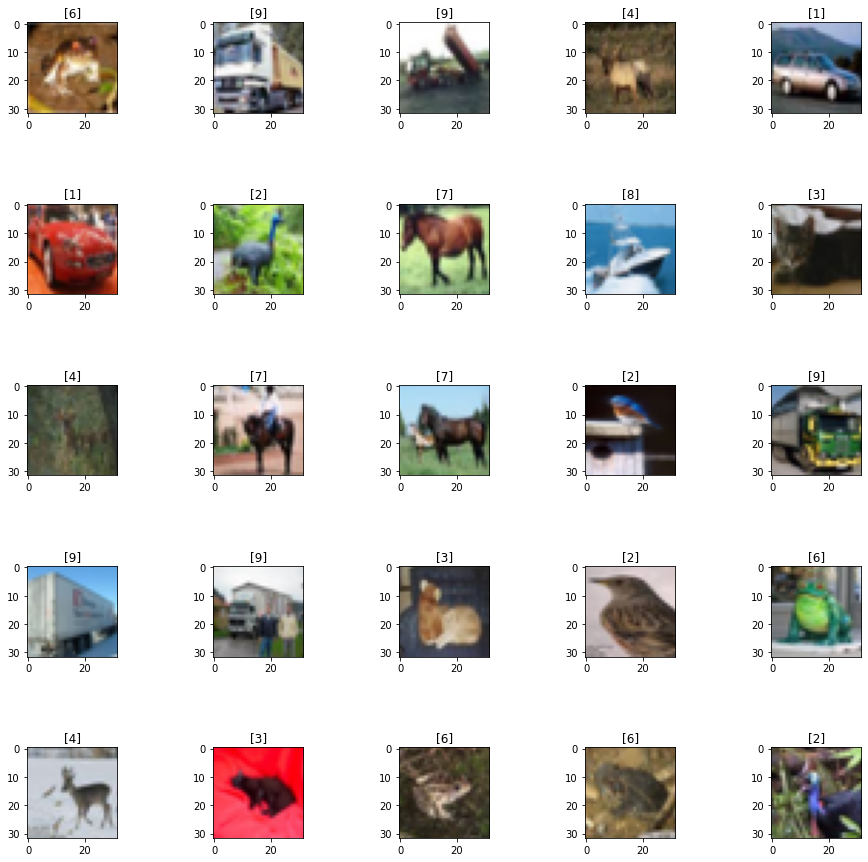

781/781 [==============================] - 46s 48ms/step - loss: 1.5621 - accuracy: 0.5260 - val_loss: 2.0726 - val_accuracy: 0.3094
Teacher Model acc:  0.30939504504203796
781/781 [==============================] - 22s 23ms/step - loss: 2.3082 - accuracy: 0.2741 - val_loss: 2.6552 - val_accuracy: 0.1005
Student Model acc:  0.10046073794364929
156/156 [==============================] - 4s 18ms/step - loss: 0.3712
Distilled Student Model acc:  0.36970466


In [7]:
def main_model():
  learning_rate = 0.001
  batch_size = 64
  epochs = 1

  data = InputPipeline()
  X_train, y_train, X_test, y_test = data.load_dataset()
  train_dataset, test_dataset = data.__call__()

  visualize = Visualize(X_train, y_train)
  visualize.__call__()

  teacher_model = TeacherModel(train_dataset=train_dataset,
                test_dataset=test_dataset)
  teacher_model.__call__()

  student_model = StudentModel(train_dataset=train_dataset,
                test_dataset=test_dataset)
  student_model.__call__()

  distilled_model = DistillatedModel(teacher_model.xception_model(),
                                     student_model.mobilenet_model())
  distilled_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False),
                          metrics=["accuracy"])
  distilled_model.fit(train_dataset,batch_size=batch_size,epochs=epochs)
  score = distilled_model.evaluate(test_dataset,batch_size=batch_size)
  print("Distilled Student Model acc: ", score[1])

if __name__ == "__main__":
  main_model()